In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile

In [16]:
# Allow truncated images to load
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Directories for dataset
data_dir = "/kaggle/input/augmented-with-similar-dataset/augmented with similar mild"

# Image Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

# Data Augmentation & Preprocessing
datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

def safe_flow_from_directory(*args, **kwargs):
    while True:
        try:
            generator = datagen.flow_from_directory(*args, **kwargs)
            return generator
        except OSError:
            print("Skipping a corrupted image...")

train_generator = safe_flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = safe_flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

num_classes = len(train_generator.class_indices)

# Define the Capsule Network Model
class ReinforcedCapsNet(keras.Model):
    def __init__(self, num_classes):
        super(ReinforcedCapsNet, self).__init__()
        self.conv1 = layers.Conv2D(64, (5, 5), activation='relu', padding='same')
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.primary_caps = layers.Conv2D(256, (9, 9), strides=2, activation='relu')
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.primary_caps(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Initialize and Compile Model
model = ReinforcedCapsNet(num_classes)
model.build(input_shape=(None, IMG_SIZE, IMG_SIZE, 3))
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train Model
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

# Evaluate Model
y_true, y_pred = [], []
for images, labels in val_generator:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    if len(y_true) >= val_generator.samples:
        break

# Classification Report
class_labels = list(train_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Found 766 images belonging to 7 classes.
Found 188 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'reinforced_caps_net_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 822ms/step - accuracy: 0.2767 - loss: 1.8213 - val_accuracy: 0.4415 - val_loss: 1.6868
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 733ms/step - accuracy: 0.4419 - loss: 1.4845 - val_accuracy: 0.4947 - val_loss: 1.5298
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 737ms/step - accuracy: 0.5315 - loss: 1.3242 - val_accuracy: 0.5372 - val_loss: 1.5251
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 730ms/step - accuracy: 0.6000 - loss: 1.1280 - val_accuracy: 0.5532 - val_loss: 1.3529
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 756ms/step - accuracy: 0.5936 - loss: 1.1349 - val_accuracy: 0.5638 - val_loss: 1.5162
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 723ms/step - accuracy: 0.6337 - loss: 1.0203 - val_accuracy: 0.5372 - val_loss: 1.5975
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 742ms/step - accuracy: 0.6244 - loss: 1.0144 - val_accuracy: 0.5957 - val_loss: 1.8678
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 762ms/step - accuracy: 0.6500 - loss: 0.9425 - val_accuracy: 0.590

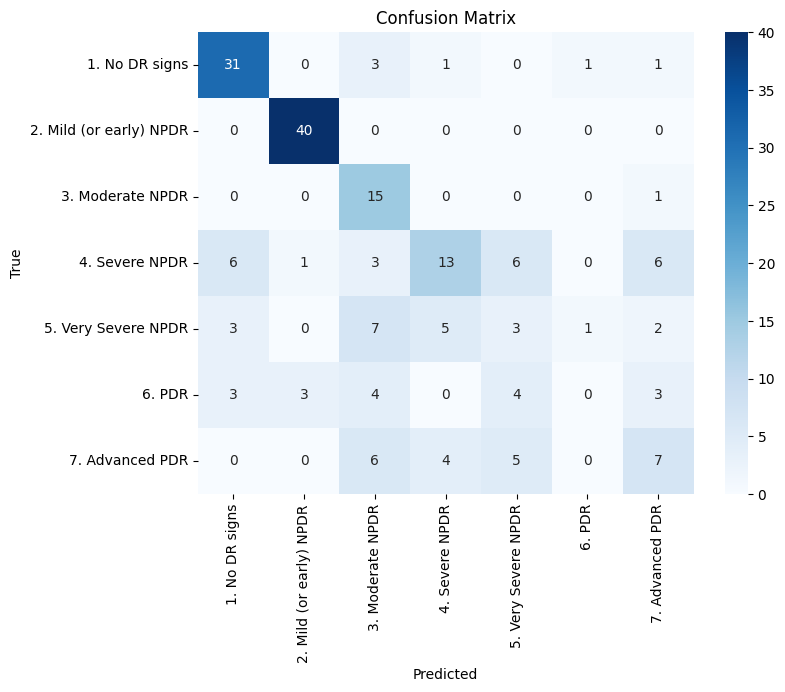

Accuracy: 0.5798
Precision: 0.4438
Recall (Sensitivity): 0.5154
F1-Score: nan
Specificity: 0.8789


<ipython-input-17-ac90a53ee71f>:18: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


In [17]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Compute Metrics
TN = np.diag(cm).sum() - cm.sum(axis=0)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)
accuracy = np.trace(cm) / np.sum(cm)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {np.mean(precision):.4f}")
print(f"Recall (Sensitivity): {np.mean(recall):.4f}")
print(f"F1-Score: {np.mean(f1_score):.4f}")
print(f"Specificity: {np.mean(specificity):.4f}")